In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.colors import LogNorm
from numpy import pi, cos,sin
from astropy.wcs import WCS
import os
import re

from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.time import Time

from astroquery import sdss
from astroquery.simbad import Simbad 
from astroquery import sdss
from astroquery.skyview import SkyView

nano_maggies_to_Jy = 3.631e-6 # constant of conversion

if not(os.path.isdir('figs')):
    os.makedirs('figs')
    

ModuleNotFoundError: No module named 'matplotlib'

In [6]:
name_input = "Mrk 421" # name of the object; if empty coordinates are used
ra_deg_input = 166.113808  # ra in degree
dec_deg_input = 38.208833 # dec in degree
radius_input = 3.0 # arcmin
plotsky_flag= True
band='u' #  it can be 'u','g','r','i','z'
plotspectrum_flag=True
plottime_flag=True




In [23]:
npix=int(2*radius_input*60.) # if image is from SkyView service, pixels will be 1''
npix=str(npix)+','+str(npix)
MODE=1 # only primary  MODE=2 is only secondary
pix_size=1 #pixel size in arcmin





In [8]:
if name_input == "":
    ra_degree = ra_deg_input
    dec_degree = dec_deg_input
else:
    result_simbad = Simbad.query_object(name_input, wildcard=True)
    ra_simbad = result_simbad['RA'].data[0] # here it is a string!
    dec_simbad = result_simbad['DEC'].data[0]
    ra_degree=Angle(ra_simbad,unit='hourangle').degree
    dec_degree=Angle(dec_simbad,unit='deg').degree
    
source = SkyCoord(ra_degree,dec_degree,unit='degree')
radius = Angle(radius_input, unit='arcmin')

photoobj_fields=['run', 'rerun','camcol','field','ra','dec','mode',
                    'psfFlux_u', 'psfFlux_g','psfFlux_r','psfFlux_i','psfFlux_z',
                 'psfFluxIvar_u','psfFluxIvar_g','psfFluxIvar_r','psfFluxIvar_i','psfFluxIvar_z',
                    'TAI_u', 'TAI_g', 'TAI_r', 'TAI_i', 'TAI_z','objID', 'thingId']

query1 = sdss.SDSS.query_region(source, radius=radius,data_release=16,photoobj_fields=photoobj_fields)

if query1 is not None:
    query={}
    for k in query1.keys():
        query[k]=query1[k].data
else:
    query=None

In [9]:
# Some logic is needed to establish relation between "DSS2 blue" and "u" etc
img = SkyView.get_images(position=ra_simbad+','+dec_simbad,survey=['DSS2 Blue','DSS2 IR','DSS2 Red'],pixels=npix,coordinates='J2000',grid=True,gridlabels=True)

In [11]:
b = img[0][0]
g = img[1][0]
r = img[2][0]

bi = (b.data)
ri = (r.data)
gi = (g.data)



Text(0, 0.5, 'DEC')

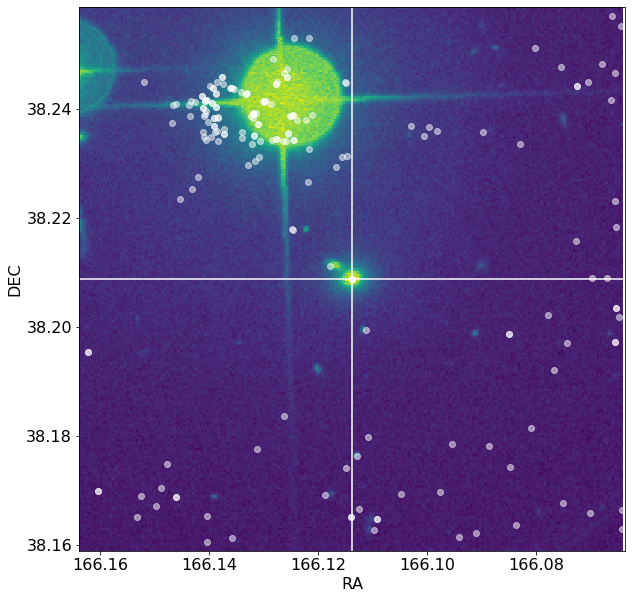

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(bi,interpolation='none',aspect='equal',extent=[b.header['CRVAL1']-(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1'],
                                                           b.header['CRVAL1']+(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1'],
                                                           b.header['CRVAL2']+(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2'],
                                                           b.header['CRVAL2']-(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2']])
fig.gca().invert_yaxis()
plt.axvline(ra_degree,color='white')
plt.axhline(dec_degree,color='white')
plt.scatter(query['ra'],query['dec'],color='white',alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('RA',fontsize=16)
plt.ylabel('DEC',fontsize=16)




In [21]:
dec_min=b.header['CRVAL2']-(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2']
dec_max=b.header['CRVAL2']+(b.header['NAXIS2']-b.header['CRPIX2'])*b.header['CDELT2']
ra_max=b.header['CRVAL1']-(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1']
ra_min=b.header['CRVAL1']+(b.header['NAXIS1']-b.header['CRPIX1'])*b.header['CDELT1']
print(ra_min,ra_max,dec_min,dec_max)

166.06413890285 166.16386109715 38.15893890285 38.25866109715


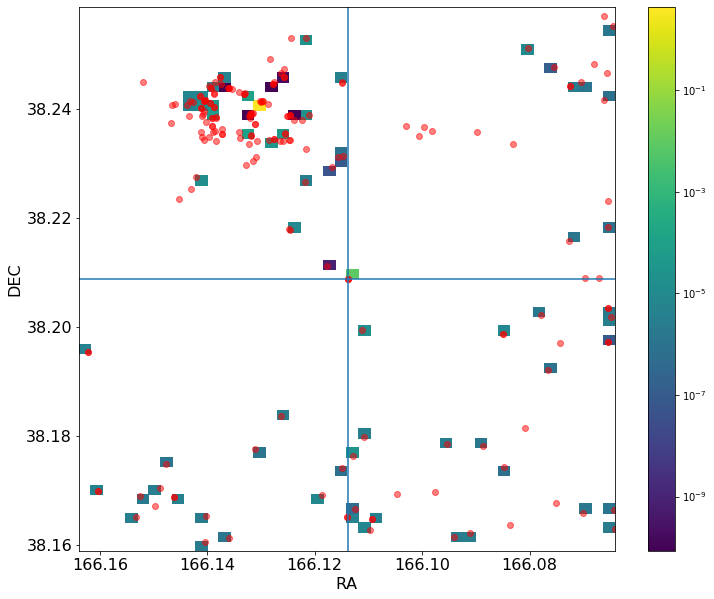

In [36]:
# different representation of the images, in terms of "deconvolved" flux from sources:
pix_size=0.1
def pplot(qquery, primary=True):
    if qquery==None:
        return -1
    Nra      = int((ra_max-ra_min)*cos(dec_degree*pi/180.) / (pix_size/60.))
    Ndec     = int((dec_max-dec_min)/(pix_size/60.))
    ra_b     = np.linspace(ra_min, ra_max, Nra)
    dec_b    = np.linspace(dec_min, dec_max, Ndec)

    fig = plt.figure(figsize=(12,10))
    if primary:
        mode=np.where(qquery['mode']==1)[0]
    else:
        mode = np.range(len(qquery['mode']))
    w=qquery['psfFlux_'+band][mode]*nano_maggies_to_Jy

    plt.hist2d(qquery['ra'][mode], qquery['dec'][mode], bins=([ra_b, dec_b]), 
               weights=w,norm=LogNorm())
    plt.colorbar()
    plt.scatter(query['ra'],query['dec'],alpha=0.5,color='red')
    plt.axhline(dec_degree)# dec
    plt.axvline(ra_degree)# ra
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.xlabel('RA',fontsize=16)
    plt.ylabel('DEC',fontsize=16)

    plt.gca().invert_xaxis()
    plt.savefig('figs/figure_sky.png')
    return 0

flag1=pplot(query)

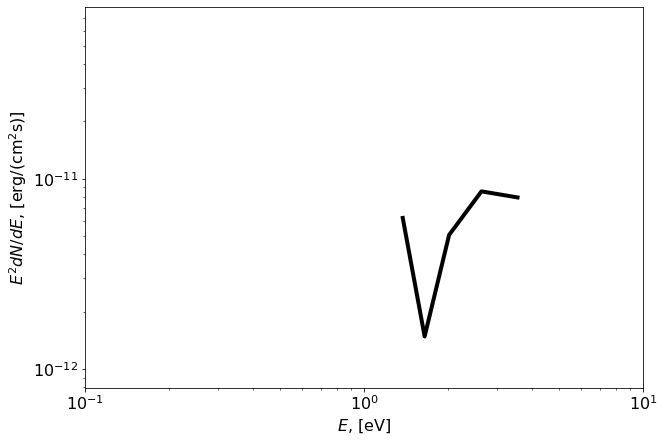

In [45]:
wavelength=np.array([3543,4770,6231,7625,9134]) # in Angstroem
wavelength=wavelength*1e-8 # in cm
frequency=3.e10/wavelength # in Hz
energy=2*pi*6.67e-16*frequency # in eV
factor=1e-24*frequency # conversion of Jy to erg/cm2s

def plot_spectrum(qquery):
    if qquery==None:
        return -1
    filters={'u':3543, 'g':4770, 'r': 6231,'i':7625,'z':9134}
    # Wavelength (Angstroms)
    # Ultraviolet (u) 3543
    # Green (g) 4770
    # Red (r) 6231
    # Near Infrared (i) 7625
    # Infrared (z) 9134
    plt.figure(figsize=(10,7))
    sep=np.array([])
    for i in range(len(qquery['run'])):
        rai    = qquery['ra'][i]
        deci   = qquery['dec'][i]
        coordi = SkyCoord(Angle(rai, unit='degree').degree, Angle(deci, unit='degree').degree, unit='deg')
        sep=np.append(sep,source.separation(coordi).arcmin)
    index=np.argmin(sep)
    label=['u','g','r','i','z']
    x = np.array([filters[i] for i in label])
    y1 = np.array([qquery['psfFlux_'+i][index] for i in label]) # in nanomaggies
    y1_err = np.array([qquery['psfFluxIvar_'+i][index] for i in label]) # in nanomaggies
    y = y1 * nano_maggies_to_Jy*factor # in Jy
    y_err = y1_err * nano_maggies_to_Jy*factor # in Jy
    plt.errorbar(energy, y,y_err,color='black',linewidth=4)
    plt.xlabel('$E$, [eV]',fontsize=16)
    plt.ylabel('$E^2dN/dE$, [erg/(cm$^2$s)]',fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.1,10)
    plt.ylim(y[0]/10.,y[0]*10)
    plt.tick_params(axis='both', which='major', labelsize=16)

    plt.savefig("figs/figure_spectrum.png")
    return 0
flag2=plot_spectrum(query)




1
52755.21992409884 8.894926187129552e-12 1.385395598221846e-18
52755.22075427372 2.3687570685534588e-12 5.766391099999998e-18
52755.22158459074 4.530362162734714e-12 5.451665914780934e-19
52755.22241392407 7.444146198295082e-12 1.0603817636065575e-19
52755.22324426481 4.477551311692576e-12 2.1511492583753006e-19
52755


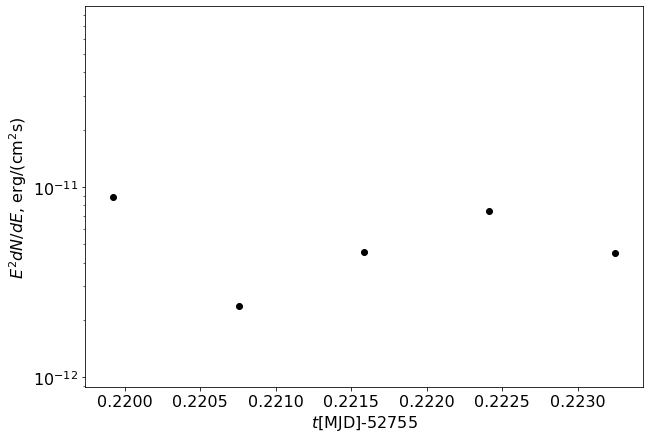

In [65]:
def plot_time(qquery):
    if qquery==None:
        return -1
    def MJD(t): # Modified Julian Date format
        return t/(24*3600)
    
    
    sep=np.array([])
    for i in range(len(qquery['ra'])):
        sep=np.append(sep,source.separation(SkyCoord(qquery['ra'][i],qquery['dec'][i], unit='deg')).deg)
    i_min=[np.argmin(sep),]

    thingid=query['thingId'][i_min]

    ilist=np.where((query['thingId']==thingid)&((query['mode']==1)|(query['mode']==2)))[0]
    print(len(ilist))
    i_mode1= np.where(query['mode'][ilist]==1)[0]

    plt.figure(figsize=(10,7))
    label=['r','i','u','z','g']
    colors=['green', 'blue','black','red','magenta']
    x = {}
    y = {}
    y_err= {}
    ll=np.array([3543,4770,6231,7625,9134])
    conv=1e-24*3e10/(ll/1e8)

    tt=[]
    ff=[]
    ff_err=[]
    for ii in ilist:
        j=0
        for lab in label:
            if len(x)<5:
                x[lab] = np.array([qquery['TAI_'+lab][ii],])
                y[lab] = np.array([qquery['psfFlux_'+lab][ii],])*nano_maggies_to_Jy*conv[j]
                y_err[lab] = np.array([qquery['psfFluxIvar_'+lab][ii],])*nano_maggies_to_Jy*conv[j]
                tt.append(qquery['TAI_'+lab][ii]/(24*3600))
                ff.append(qquery['psfFlux_'+lab][ii]*nano_maggies_to_Jy*factor[j])
                ff_err.append(qquery['psfFluxIvar_'+lab][ii]*nano_maggies_to_Jy*factor[j])
                print(tt[-1],ff[-1],ff_err[-1])
                j+=1

            else:
                x[lab] = np.concatenate([x[lab], [qquery['TAI_'+lab][ii],]])
                y[lab] = np.concatenate([y[lab], [qquery['psfFlux_'+lab][ii],]])*nano_maggies_to_Jy*conv[j]
                y_err[lab] = np.concatenate([y[lab], [qquery['psfFluxIvar_'+lab][ii],]])*nano_maggies_to_Jy*conv[j]
                tt.append(qquery['TAI_'+lab][ii]/(24*3600))
                ff.append(qquery['psfFlux_'+lab][ii]*nano_maggies_to_Jy*factor[j])
                ff_err.append(qquery['psfFluxIvar_'+lab][ii]*nano_maggies_to_Jy*factor[j])
                print(tt[-1],ff[-1],ff_err[-1])
                j+=1

    t0 = int(min(tt))
    print(t0)
    
    plt.errorbar(np.array(tt)-t0,ff,yerr=ff_err,color='black',linestyle='none')
    plt.scatter(np.array(tt)-t0,ff,color='black')

        
    plt.xlabel('$t$[MJD]-'+str(t0),fontsize=16)
    plt.ylabel('$E^2dN/dE$, erg/(cm$^2$s)', fontsize=16)
    plt.yscale('log')
    plt.ylim(ff[0]/10.,ff[0]*10)

    plt.tick_params(axis='both', which='major', labelsize=16)


    plt.savefig("figs/figure_time.png")
    return 0
flag3=plot_time(query)

In [ ]:
image1_filename = "./figs/figure_sky.png"
message1 = 'Completed' if flag1==0 else 'Error'
image2_filename = "./figs/figure_spectrum.png"
message2 = 'Completed' if flag2==0 else 'Error'
image3_filename = "./figs/figure_time.png"
message3 = 'Completed' if flag3==0 else 'Error'